<h1>Reinforcement Learning</h1>

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math
from collections import defaultdict
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
np.random.seed(0)

<h2>Q1</h2>
<h3>Reward1</h3>

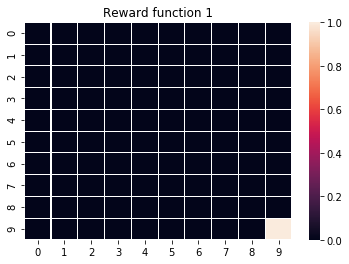

In [18]:
reward1 = np.zeros((10,10))
reward1[9,9] = 1
#cmap = ListedColormap(sns.color_palette("Blues"))
#cmap = sns.cm.rocket_r
plt.title("Reward function 1")
sns.heatmap(reward1, linewidths=.1)

<h3>Reward2</h3>

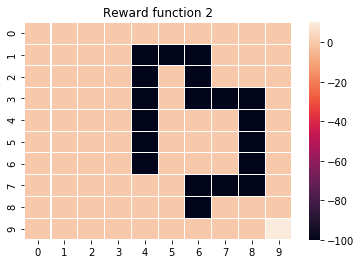

In [19]:
reward2 = np.zeros((10,10))
reward2[[i for i in range(1,7)] , 4] = -100
reward2[1,5] = -100
reward2[[i for i in range(1,4)] , 6] = -100
reward2[[i for i in range(7,9)] , 6] = -100
reward2[3,7] = -100
reward2[7,7] = -100
reward2[[i for i in range(3,8)] , 8] = -100
reward2[9,9] = 10
plt.title("Reward function 2")
sns.heatmap(reward2, vmax=10, linewidths=.1)

<h3>State Space</h3>

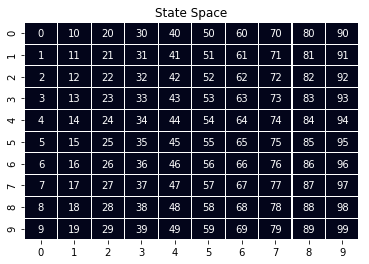

In [20]:
vals = np.arange(0,100)
state_vals = [vals[i:i+10] for i in range(0,100,10)]
state_space = np.array(state_vals).T
state_space
plt.title("State Space")
sns.heatmap(state_space, annot=True, fmt="d", linewidths=.1, vmax=0, cbar=False)

In [21]:
a = np.empty(10)
a.fill(-1)
modified_state_space = np.vstack((a, state_space, a))
b = np.empty((12,1))
b.fill(-1)
modified_state_space = np.hstack((b, modified_state_space, b))
modified_state_space

array([[ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
         -1.],
       [ -1.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.,
         -1.],
       [ -1.,   1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91.,
         -1.],
       [ -1.,   2.,  12.,  22.,  32.,  42.,  52.,  62.,  72.,  82.,  92.,
         -1.],
       [ -1.,   3.,  13.,  23.,  33.,  43.,  53.,  63.,  73.,  83.,  93.,
         -1.],
       [ -1.,   4.,  14.,  24.,  34.,  44.,  54.,  64.,  74.,  84.,  94.,
         -1.],
       [ -1.,   5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95.,
         -1.],
       [ -1.,   6.,  16.,  26.,  36.,  46.,  56.,  66.,  76.,  86.,  96.,
         -1.],
       [ -1.,   7.,  17.,  27.,  37.,  47.,  57.,  67.,  77.,  87.,  97.,
         -1.],
       [ -1.,   8.,  18.,  28.,  38.,  48.,  58.,  68.,  78.,  88.,  98.,
         -1.],
       [ -1.,   9.,  19.,  29.,  39.,  49.,  59.,  69.,  79.,  89.,  99.,
         -1.],
       [ -1.,  -1.,  

In [22]:
actions = ["R", "L", "U", "D"]
actions

['R', 'L', 'U', 'D']

In [23]:
def neighbors(currentst, nextst):
    if nextst == currentst or nextst == currentst+1 or nextst == currentst-1 or nextst == currentst+10 or nextst == currentst-10:
        if (currentst%10 == 0 and nextst%10 == 9) or (currentst%10 == 9 and nextst%10 == 0):
            return False
        return True
    return False

In [24]:
# r,c = positions of current_state (s) in modified state space
# next_st is the state to transition to (s') 
def get_transition_probability(current_state, next_st,  r, c, action, w = 0.1, modified_state_space=modified_state_space):
    n = modified_state_space.shape[1]
    if action == "R":
        next_state = modified_state_space[r, c+1]
    if action =="L":
        next_state = modified_state_space[r, c-1]
    if action == "U":
        next_state = modified_state_space[r-1, c]
    if action == "D":
        next_state = modified_state_space[r+1, c]
   
    if next_st == -1 or not neighbors(current_state, next_st):
        # transition not possible
        return 0  
    if next_state == -1 and (current_state ==0 or current_state==9 or current_state==90 or current_state==99):
        # corner states action moving off grid 
        if next_st == current_state:
            return (1-w+w/4+w/4)
        else:
            return (w/4)
    if next_state != -1 and (current_state ==0 or current_state==9 or current_state==90 or current_state==99):
        # corner states action moving on grid 
        if next_st == current_state:
            return (w/4+w/4)
        if next_state == next_st:
            return (1-w+w/4)
        else:
            return (w/4)
        
    if r == 1 or r == n-2 or c == 1 or c == n-2:
        # edge states
        if next_state == -1:
            # edge states action moving off grid
            if next_st == current_state:
                return (1-w+w/4)
            else:
                return (w/4)
        else:
            # edge states action moving on grid
            if next_st == next_state:
                return (1-w+w/4)
            else:
                return (w/4)
    else:
        # non boundary states
        if next_state == next_st:
            return (1-w+w/4)
        if neighbors(current_state, next_st) and current_state!=next_st:
            return (w/4)
        else:
            # action not possible
            return (0)
        

In [25]:
get_transition_probability(19, 19,  10, 2, "R", w = 0.1)

0.025

In [26]:
def get_neighbors(r, c, state_space=state_space):
    current_state = state_space[r,c]
    neighbor_list = [(r,c)]

    # corner states
    if current_state == 0:
        neighbor_list.extend([(r+1,c), (r,c+1)])
        return neighbor_list
    if current_state == 9:
        neighbor_list.extend([(r-1,c), (r,c+1)])
        return neighbor_list
    if current_state == 90:
        neighbor_list.extend([(r+1,c), (r,c-1)])
        return neighbor_list
    if current_state == 99:
        neighbor_list.extend([(r-1,c), (r,c-1)])
        return neighbor_list
    
    # edge states
    if r==0 and current_state!=0 and current_state!=90:
        neighbor_list.extend([(r,c+1), (r,c-1), (r+1,c)])
        return neighbor_list
    if r==9 and current_state!=9 and current_state!=99:
        neighbor_list.extend([(r,c+1), (r,c-1), (r-1,c)])
        return neighbor_list
    if c==0 and current_state!=0 and current_state!=9:
        neighbor_list.extend([(r,c+1), (r-1,c), (r+1,c)])
        return neighbor_list
    if c==9 and current_state!=90 and current_state!=99:
        neighbor_list.extend([(r,c-1),(r-1,c),(r+1,c)])
        return neighbor_list
    # other states
    else:
        neighbor_list.extend([(r+1,c),(r-1,c),(r,c+1),(r,c-1)])
        return neighbor_list

In [27]:
def get_estimation(s, reward, value, discount, modified_state_space=modified_state_space, action_set=actions):
    actual_neighbors = get_neighbors(s[0]-1, s[1]-1)
    neighbor_states = [(i[0]+1, i[1]+1) for i in actual_neighbors]
    probs = defaultdict(list)
    action_map = {ac:actions.index(ac) for ac in action_set}
    estimations = np.zeros((len(action_set), len(neighbor_states)))

    for ac in action_set:
        for ns in neighbor_states:
            probs[ac].append(get_transition_probability(modified_state_space[s], modified_state_space[ns],  s[0], s[1], ac))
     
    for ac in action_set:
        for n in range(len(actual_neighbors)):
            estimations[action_map[ac], n] = probs[ac][n] * (reward[actual_neighbors[n]]
                                                             + discount*value[actual_neighbors[n]])
            
    return estimations

In [29]:
def value_iteration(reward, state_space, action_set, w, discount, epsilon):
    n = len(state_space)
    states = [(i,j) for i in range(n) for j in range(n)]
    optimal_value = np.zeros((n,n))
    optimal_policy = np.zeros((n,n))
    delta = math.inf
    # estimation step
    while delta > epsilon:
        delta = 0
        optimal_value_copy = np.zeros((n,n))
        for s in states:
            v = optimal_value[s]
            action_estimations = get_estimation((s[0]+1,s[1]+1), reward, optimal_value, discount)
            optimal_value_copy[s] = max(np.sum(action_estimations, axis=1))
            #optimal_policy[s] = np.argmax(np.sum(action_estimations, axis=1))
            delta = max(delta, abs(v - optimal_value_copy[s]))
            
        # parallel update
        optimal_value = np.copy(optimal_value_copy)
            
    # computation step
    for s in states:
        action_estimations = get_estimation((s[0]+1,s[1]+1), reward, optimal_value, discount)
        optimal_policy[s] = np.argmax(np.sum(action_estimations, axis=1))

    return optimal_value, optimal_policy

In [30]:
value1, policy1 = value_iteration(reward1, state_space, actions, 0.1, 0.8, 0.01)
print(value1)

[[ 0.0442397   0.06457398  0.09118409  0.12504106  0.16807826  0.22269335
   0.29198796  0.37988042  0.49134892  0.61001145]
 [ 0.06457398  0.08833385  0.12185345  0.16476116  0.21945345  0.28917752
   0.37804302  0.49122817  0.63338372  0.78751905]
 [ 0.09118409  0.12185345  0.16458987  0.21930412  0.28906986  0.3779887
   0.49131731  0.63565109  0.81751608  1.01875794]
 [ 0.12504106  0.16476116  0.21930412  0.28906536  0.37798653  0.49132035
   0.63576137  0.81977022  1.05235181  1.31521922]
 [ 0.16807826  0.21945345  0.28906986  0.37798653  0.49132036  0.63576402
   0.81985582  1.05442573  1.35173221  1.69523349]
 [ 0.22269335  0.28917752  0.3779887   0.49132035  0.63576402  0.81985701
   1.05448231  1.35348475  1.73334073  2.18239181]
 [ 0.29198796  0.37804302  0.49131731  0.63576137  0.81985582  1.05448231
   1.3535115   1.73462151  2.21968743  2.80696303]
 [ 0.37988042  0.49122817  0.63565109  0.81977022  1.05442573  1.35348475
   1.73462151  2.22036214  2.83941767  3.60778693]
 

<h2>Q2</h2>
<h3>Reward1 optimal values</h3>

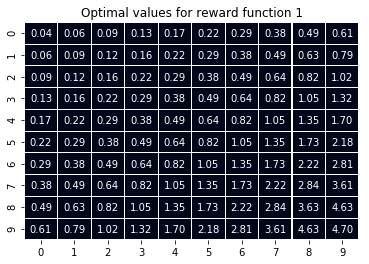

In [31]:
plt.title("Optimal values for reward function 1")
sns.heatmap(state_space, annot=value1, fmt='.2f', linewidths=.1, vmax=0, cbar=False)

<h2>Q3</h2>
<h3>Reward1 Heatmap</h3>

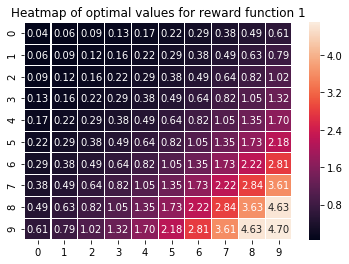

In [32]:
plt.title("Heatmap of optimal values for reward function 1")
sns.heatmap(value1, annot=True, fmt='.2f', linewidths=.1)

In [33]:
print(policy1)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  3.  3.]
 [ 3.  3.  0.  0.  0.  0.  3.  3.  3.  3.]
 [ 3.  3.  0.  0.  0.  3.  3.  3.  3.  3.]
 [ 3.  3.  3.  0.  3.  3.  3.  3.  3.  3.]
 [ 3.  3.  3.  0.  0.  3.  3.  3.  3.  3.]
 [ 3.  3.  0.  0.  0.  3.  3.  3.  3.  3.]
 [ 3.  0.  0.  0.  0.  0.  3.  3.  3.  3.]
 [ 3.  0.  0.  0.  0.  0.  0.  0.  3.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [34]:
value2, policy2 = value_iteration(reward2, state_space, actions, 0.1, 0.8, 0.01)
print(value2)

[[  6.46710402e-01   7.90798480e-01   8.20813046e-01   5.25100092e-01
   -2.38647637e+00  -4.23692968e+00  -1.92337440e+00   1.12809691e+00
    1.59116227e+00   2.03482701e+00]
 [  8.27724228e-01   1.01773259e+00   1.06157960e+00  -1.87921677e+00
   -6.75466905e+00  -8.68371372e+00  -6.37348342e+00  -1.29836115e+00
    1.92477470e+00   2.60689337e+00]
 [  1.06131226e+00   1.31300108e+00   1.44578824e+00  -1.63521080e+00
   -6.75775652e+00  -1.39166346e+01  -9.65320172e+00  -5.51481504e+00
   -1.34600438e-01   3.35547821e+00]
 [  1.35778625e+00   1.68918212e+00   1.94390703e+00  -1.24321750e+00
   -6.33921636e+00  -7.98277134e+00  -7.94729165e+00  -9.43445243e+00
   -1.91815510e+00   4.38704487e+00]
 [  1.73393379e+00   2.16807921e+00   2.58589509e+00  -7.36489716e-01
   -5.84672738e+00  -3.25840283e+00  -3.24107127e+00  -7.43449847e+00
    1.71515827e+00   9.15952421e+00]
 [  2.21111919e+00   2.77755323e+00   3.41334536e+00  -3.81397000e-02
   -5.11411173e+00  -5.53379765e-01  -4.87536

<h2>Q6</h2>
<h3>Reward2 optimal values</h3>

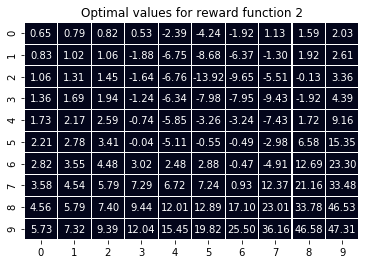

In [35]:
plt.title("Optimal values for reward function 2")
sns.heatmap(state_space, annot=value2, fmt='.2f', linewidths=.1, vmax=0, cbar=False)

<h2>Q7</h2>
<h3>Reward2 Heatmap</h3>

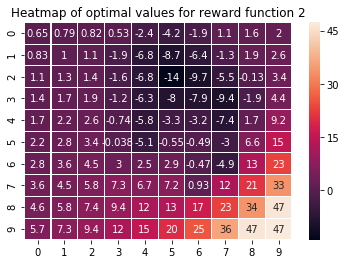

In [36]:
plt.title("Heatmap of optimal values for reward function 2")
sns.heatmap(value2, annot=True, linewidths=.1)

In [37]:
print(policy2)

[[ 3.  3.  3.  1.  1.  0.  0.  0.  0.  3.]
 [ 3.  3.  3.  1.  1.  2.  0.  0.  0.  3.]
 [ 3.  3.  3.  1.  1.  3.  0.  0.  0.  3.]
 [ 3.  3.  3.  1.  1.  3.  3.  2.  0.  3.]
 [ 3.  3.  3.  1.  1.  3.  3.  3.  0.  3.]
 [ 3.  3.  3.  1.  1.  3.  3.  1.  0.  3.]
 [ 3.  3.  3.  3.  3.  3.  1.  1.  0.  3.]
 [ 3.  3.  3.  3.  3.  3.  1.  3.  3.  3.]
 [ 0.  0.  0.  3.  3.  3.  3.  3.  3.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [38]:
arrow_map = {0:'\u2192', 1:'\u2190', 2:'\u2191',3:'\u2193'}  # RLUD = 0123

In [39]:
def arrow_conversion(policy):
    policy_arrows = np.array(policy, dtype="object")
    for row in range(len(policy)):
        for col in range(len(policy)):
            idx = policy[row,col]
            policy_arrows[row,col] = arrow_map[idx]
    return policy_arrows

<h2>Q5</h2>
<h3>Reward1 optimal policy</h3>

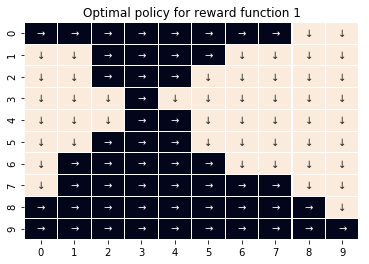

In [40]:
policy1_arrows = arrow_conversion(policy1)
plt.title("Optimal policy for reward function 1")
sns.heatmap(policy1, annot=policy1_arrows, fmt='', linewidths=.1, cbar=False)

<h2>Q9</h2>
<h3>Reward2 optimal policy</h3>

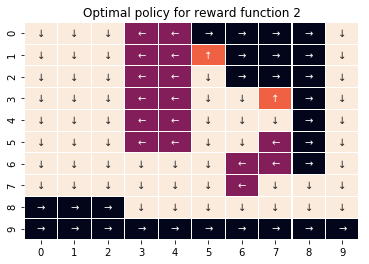

In [41]:
policy2_arrows = arrow_conversion(policy2)
plt.title("Optimal policy for reward function 2")
sns.heatmap(policy2, annot=policy2_arrows, fmt='', linewidths=.1, cbar=False)

<h1>Inverse Reinforcement Learning</h1>

In [42]:
lambda_range = np.linspace(0, 5, 500)

In [43]:
def accuracy(agent_actions, expert_actions):
    n = len(agent_actions)
    mlist = []
    for i in range(0,n):
        for j in range(0,n):
            if agent_actions[(i,j)] == expert_actions[(i,j)]:
                mlist.append(1)
            else:
                mlist.append(0)
                
    return float(sum(mlist)/len(mlist))

In [44]:
def get_row_column(current_state, state_space=state_space):
    n = len(state_space)
    return current_state%n, int(current_state/n)

In [45]:
def get_transition_prob_matrix(action, state_space, modified_state_space=modified_state_space):
    n = len(state_space)
    dim = n*n
    prob_matrix = np.zeros((dim,dim))
    for i in range(0,dim):
        for j in range(0,dim):
            r, c = get_row_column(i)
            prob_matrix[i,j] = get_transition_probability(i, j, r+1, c+1, action)
    return prob_matrix

In [46]:
def normalize(vals):
    min_val = np.min(vals)
    max_val = np.max(vals)
    return (vals - min_val) / (max_val - min_val)

In [201]:
def lp_irl(trans_probs, policy, gamma=0.8, l1=10, R_max=10, state_space=state_space, actions=actions):
    n = len(state_space)
    num_states, _, num_actions = n*n, n*n, len(actions)
    num_states = int(num_states)
    num_actions = int(num_actions)

    # Formulate a linear IRL problem
    D = np.zeros([2 * num_states * (num_actions + 1), 3 * num_states])
    b = np.zeros([2 * num_states * (num_actions + 1)])
    c = np.zeros([3 * num_states])

    for i in range(num_states):
        a_opt = int(policy[get_row_column(i)])
        tmp_inv = np.linalg.inv(np.identity(num_states) - gamma * trans_probs[actions[a_opt]])
        
        cnt = 0
        for a in range(num_actions):
            if a != a_opt:
                D[i * (num_actions - 1) + cnt, :num_states] = - \
                    np.dot(trans_probs[actions[a_opt]][i, :] - trans_probs[actions[a]][i, :], tmp_inv)
                D[num_states * (num_actions - 1) + i * (num_actions - 1) + cnt, :num_states] = - \
                    np.dot(trans_probs[actions[a_opt]][i, :] - trans_probs[actions[a]][i, :], tmp_inv)
                D[num_states * (num_actions - 1) + i * (num_actions - 1) + cnt, num_states + i] = 1
                cnt += 1

    for i in range(num_states):
        D[2 * num_states * (num_actions - 1) + i, i] = 1
        b[2 * num_states * (num_actions - 1) + i] = R_max
        D[2 * num_states * (num_actions - 1) + num_states + i, i] = -1
        b[2 * num_states * (num_actions - 1) + num_states + i] = 0
        D[2 * num_states * (num_actions - 1) + 2 * num_states + i, i] = 1
        D[2 * num_states * (num_actions - 1) + 2 * num_states + i, 2 * num_states + i] = -1
        D[2 * num_states * (num_actions - 1) + 3 * num_states + i, i] = 1
        D[2 * num_states * (num_actions - 1) + 3 * num_states + i, 2 * num_states + i] = -1
        c[num_states:2 * num_states] = -1
        c[2 * num_states:] = l1

    sol = solvers.lp(matrix(c), matrix(D), matrix(b))
    rewards = sol['x'][:num_states]
    rewards = normalize(rewards) * R_max
    #print("Returning rewards", rewards)
    return rewards

In [48]:
def extract_reward_fn(P, optimal_policy, discount, lam, Rmax):
    extracted_reward_fn = lp_irl(P, optimal_policy, gamma=discount, l1=lam, R_max=Rmax)
    extracted_reward_fn = np.matrix(extracted_reward_fn).reshape(10, 10).T
    
    return extracted_reward_fn

In [50]:
def get_Pa1(Pa, optimal_policy, actions=actions, state_space=state_space):
    n = len(state_space)
    dim = n*n
    state_optimal_dir = {}
    Pa1 = np.zeros((dim,dim))
    
    for i in range(0,dim):
        state_optimal_dir[i] = optimal_policy[get_row_column(i)]
        for j in range(0,dim):
            Pa1[i,j] = Pa[actions[int(state_optimal_dir[i])]][i,j]
    return Pa1, state_optimal_dir

In [197]:
def irl(reward, optimal_policy, A=actions, w=0.1, lam_list=lambda_range, state_space=state_space,
       modified_state_space=modified_state_space, discount=0.8):
    
    n = len(state_space)
    S = range(0, n*n)
    Rmax = np.max(reward)
    Pa = {}
    for ac in actions:
        Pa[ac] = get_transition_prob_matrix(ac, state_space)
    #Pa = get_Pa(A, state_space)
    
    Pa1, state_optimal_dir = get_Pa1(Pa, optimal_policy)
    

    lam_vs_acc = []
    for lam in lam_list:
        extracted_reward_fn = np.array(extract_reward_fn(Pa, optimal_policy, discount, lam, Rmax))

        V, OAS = value_iteration(extracted_reward_fn, state_space, A, w, discount, 0.01)
        OES = optimal_policy
        lam_vs_acc.append(accuracy(OAS, OES))
        
    return lam_vs_acc, extracted_reward_fn

<h2>Question 11</h2>

In [198]:
lam_vs_acc, _ = irl(reward1, policy1)
lam_max_1 = lambda_range[np.argmax(lam_vs_acc)]

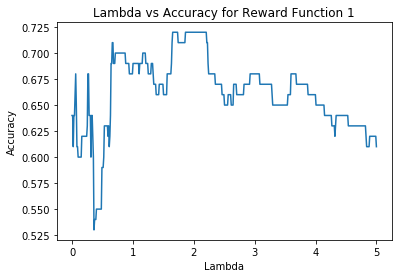

In [199]:
plt.plot(lambda_range, lam_vs_acc)
plt.title("Lambda vs Accuracy for Reward Function 1")
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.show()

<h2>Question 12</h2>

In [200]:
print("The highest accuracy is ", np.max(lam_vs_acc))
print("The lambda value with highest accuracy is ", lam_max_1)

The highest accuracy is  0.72
The lambda value with highest accuracy is  1.65330661323


<h2>Question 13</h2>

In [55]:
_, extracted_reward1 = irl(reward1, policy1)

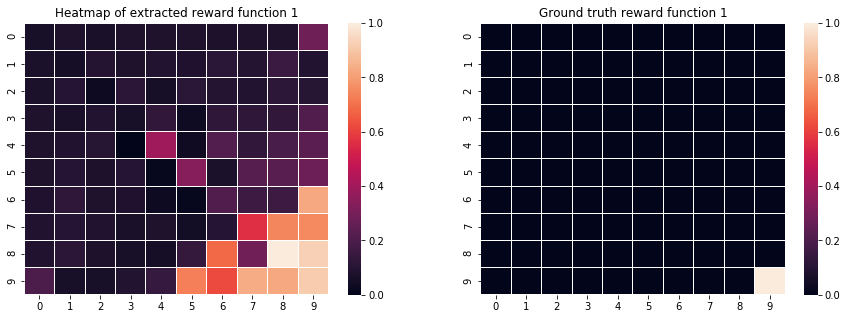

In [56]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].set_title("Heatmap of extracted reward function 1")
sns.heatmap(extracted_reward1, linewidths=.1, ax=ax[0])
plt.title("Ground truth reward function 1")
sns.heatmap(reward1, linewidths=.1, ax=ax[1])
#sns.heatmap(extracted_reward1, annot=True, fmt="0.2g", annot_kws={"size": 7}, linewidths=.1, ax=ax[1])

<h2>Question 14</h2>

In [57]:
extracted_value1, extracted_policy1 = value_iteration(extracted_reward1, state_space, actions, 0.1, discount=0.8, epsilon=0.01 )

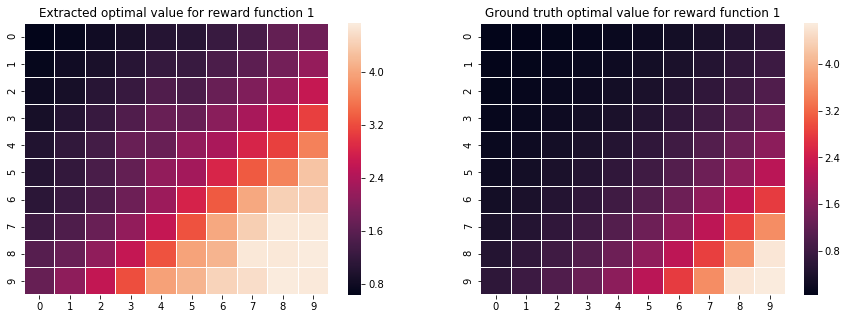

In [58]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].set_title("Extracted optimal value for reward function 1")
sns.heatmap(extracted_value1, linewidths=.1, ax=ax[0])
plt.title("Ground truth optimal value for reward function 1")
sns.heatmap(value1, linewidths=.1, ax=ax[1])
#sns.heatmap(extracted_reward1, annot=True, fmt="0.2g", annot_kws={"size": 7}, linewidths=.1, ax=ax[1])

<h2>Question 16</h2>

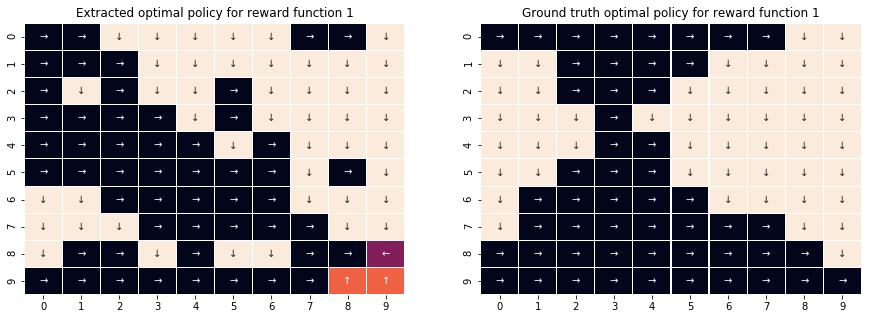

In [59]:
extracted_policy1_arrows = arrow_conversion(extracted_policy1)
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].set_title("Extracted optimal policy for reward function 1")
sns.heatmap(extracted_policy1, annot=extracted_policy1_arrows, fmt='', linewidths=.1, cbar=False, ax=ax[0])
plt.title("Ground truth optimal policy for reward function 1")
sns.heatmap(policy1, annot=policy1_arrows, fmt='', linewidths=.1, cbar=False, ax=ax[1])

<h2>Question 18</h2>

In [60]:
#lam_vs_acc, _ = irl(reward2, policy2)
lam_vs_acc, extracted_reward2 = irl(reward2, policy2)
lam_max_2 = lambda_range[np.argmax(lam_vs_acc)]

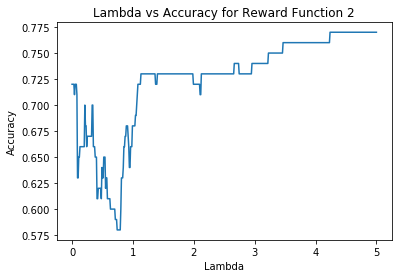

In [61]:
plt.plot(lambda_range, lam_vs_acc)
plt.title("Lambda vs Accuracy for Reward Function 2")
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.show()

<h2>Question 19</h2>

In [62]:
print("The highest accuracy is ", np.max(lam_vs_acc))
print("The lambda value with highest accuracy is ", lam_max_2)

The highest accuracy is  0.77
The lambda value with highest accuracy is  4.23847695391


<h2>Question 20</h2>

In [185]:
#_, extracted_reward2 = irl(reward2, policy2)
print(extracted_reward2)

[[  1.62509373   0.57632756   0.88369456   0.44535772   0.11245918
    1.20866169   0.30468149   1.77942403   0.52366114   4.69853477]
 [  1.50771899   1.2053405    1.15511301   0.35886897   0.16292176
    0.26636859   0.28398527   0.63898368   0.64559162   4.76705199]
 [  1.62159211   1.43808062   1.44884473   0.35383607   0.17017496
    0.29920448   0.31128052   1.03903505   0.56408435   4.93773279]
 [  1.82372934   1.67614827   1.7355969    0.3519358    0.18292814
    0.52813708   0.35903737   0.35483658   0.40760213   4.16402321]
 [  2.11138221   1.97744166   1.98929514   0.3808124    0.2108352
    0.63602001   0.38773928   0.39170594   0.47247703   4.31359162]
 [  2.47338464   2.12910736   2.47096158   0.50537298   0.41306059
    0.62422434   3.94184623   0.6181092    0.40377516   4.62983438]
 [  2.20386466   2.4840767    1.45404698   0.70604821   0.7319298
    6.08897079   1.81737326   0.20073304   0.61405613   5.45894056]
 [  4.54274392   2.20456497   4.54829721   0.           6

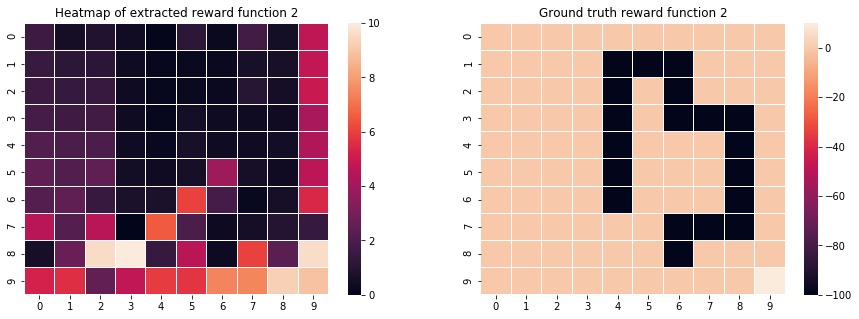

In [203]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].set_title("Heatmap of extracted reward function 2")
#cmap = ListedColormap(sns.color_palette("Blues"))
#cmap = sns.cm.rocket_r
sns.heatmap(extracted_reward2, linewidths=.1, vmin=-4, ax=ax[0])
plt.title("Ground truth reward function 2")
sns.heatmap(reward2, linewidths=.1, ax=ax[1])
#sns.heatmap(extracted_reward1, annot=True, fmt="0.2g", annot_kws={"size": 7}, linewidths=.1, ax=ax[1])

<h2>Question 21</h2>

In [65]:
extracted_value2, extracted_policy2 = value_iteration(extracted_reward2, state_space, actions, 0.1, discount=0.8, epsilon=0.01 )

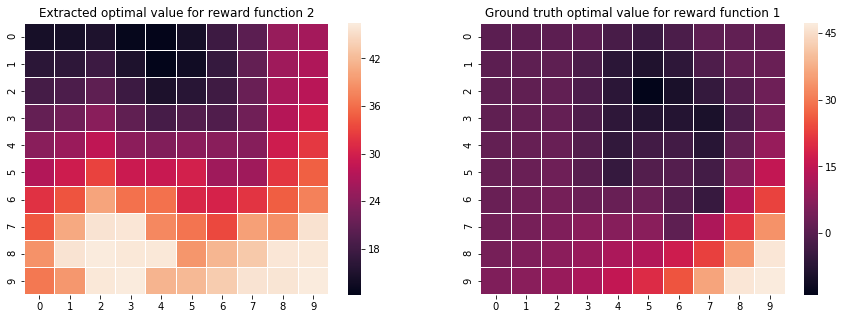

In [66]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].set_title("Extracted optimal value for reward function 2")
sns.heatmap(extracted_value2, linewidths=.1, ax=ax[0])
plt.title("Ground truth optimal value for reward function 1")
sns.heatmap(value2, linewidths=.1, ax=ax[1])
#sns.heatmap(extracted_reward1, annot=True, fmt="0.2g", annot_kws={"size": 7}, linewidths=.1, ax=ax[1])

<h2>Question 23</h2>

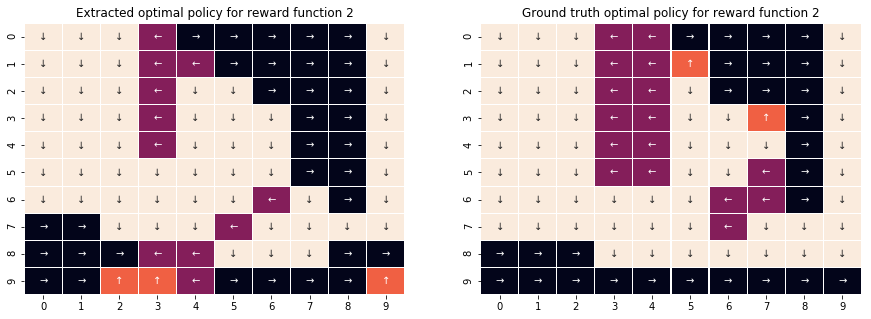

In [67]:
extracted_policy2_arrows = arrow_conversion(extracted_policy2)
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].set_title("Extracted optimal policy for reward function 2")
sns.heatmap(extracted_policy2, annot=extracted_policy2_arrows, fmt='', linewidths=.1, cbar=False, ax=ax[0])
plt.title("Ground truth optimal policy for reward function 2")
sns.heatmap(policy2, annot=policy2_arrows, fmt='', linewidths=.1, cbar=False, ax=ax[1])

<h2>Question 25</h2>

In [76]:
def deadlock_combo(s, n, optimal_policy, state_space=state_space, actions=actions):
    deadlock_combos = {"R":"L", "L":"R", "U":"D", "D":"U"}
    s_pol = actions[int(optimal_policy[get_row_column(s)])]
    n_pol = actions[int(optimal_policy[get_row_column(n)])]
    
    if deadlock_combos[s_pol] == n_pol:
        return -1
    else:
        return 1000

In [73]:
def check_deadlock(s, neighbors, optimal_policy, state_space=state_space):
    neighbor_states = [state_space[n] for n in neighbors]
    deadlock = 1000
    
    for n in neighbor_states:
        deadlock = deadlock_combo(s, n, optimal_policy)
        if deadlock == -1:
            return n
        
    return deadlock

In [249]:
def deadlock_type(s, n, optimal_policy, state_space=state_space):
    ac_s = actions[int(optimal_policy[get_row_column(s)])]
    ac_n = actions[int(optimal_policy[get_row_column(n)])]
    
    if (ac_s == "R" and n == s+10 and ac_n == "L"):
        return 1
    elif (ac_s == "L" and n == s-10 and ac_n == "R"):
        return 1
    elif (ac_s == "U" and n == s-1 and ac_n == "D"):
        return 2
    elif (ac_s == "D" and n == s+1 and ac_n == "U"):
        return 2
    else:
        return 0

In [271]:
def value_iteration2(reward, state_space, action_set, w, discount, epsilon):
    
    n = len(state_space)
    states = [(i,j) for i in range(n) for j in range(n)]
    optimal_value = np.zeros((n,n))
    optimal_policy = np.zeros((n,n))
    delta = math.inf
    # estimation step
    while delta > epsilon:
        delta = 0
        optimal_value_copy = np.zeros((n,n))
        for s in states:
            v = optimal_value[s]
            action_estimations = get_estimation((s[0]+1,s[1]+1), reward, optimal_value, discount)
            optimal_value_copy[s] = max(np.sum(action_estimations, axis=1))
            #optimal_policy[s] = np.argmax(np.sum(action_estimations, axis=1))
            delta = max(delta, abs(v - optimal_value_copy[s]))
            
        # parallel update
        optimal_value = np.copy(optimal_value_copy)
            
    # computation step
    for s in states:
        action_estimations = get_estimation((s[0]+1,s[1]+1), reward, optimal_value, discount)
        optimal_policy[s] = np.argmax(np.sum(action_estimations, axis=1))

    for s in states:
        neighbors = get_neighbors(s[0], s[1])
        deadlock = check_deadlock(state_space[s], neighbors, optimal_policy)

        if deadlock != 1000:
            # deadlock in neighbor state
            t = deadlock_type(state_space[s], deadlock, optimal_policy)
            if t == 1:
                action_estimations = get_estimation((s[0]+1,s[1]+1), reward, optimal_value, discount)
                optimal_policy[s] = actions.index("R")
            elif t == 2:
                action_estimations = get_estimation((s[0]+1,s[1]+1), reward, optimal_value, discount)
                optimal_policy[s] = actions.index("D")
           
    # best state move off the grid
    if optimal_policy[get_row_column(99)] != "R" or optimal_policy[get_row_column(99)] != "D":
        optimal_policy[get_row_column(99)] = actions.index("R")
        
    return optimal_value, optimal_policy

In [272]:
def irl2(reward, optimal_policy, A=actions, w=0.1, lam_list=lambda_range, state_space=state_space,
       modified_state_space=modified_state_space, discount=0.8):
    
    n = len(state_space)
    S = range(0, n*n)
    Rmax = np.max(reward)
    Pa = {}
    for ac in actions:
        Pa[ac] = get_transition_prob_matrix(ac, state_space)
    #Pa = get_Pa(A, state_space)
    
    Pa1, state_optimal_dir = get_Pa1(Pa, optimal_policy)
    
    P, I_P = get_P_IP(S, state_optimal_dir, Pa1, Pa, discount)
    

    lam_vs_acc = []
    for lam in lam_list:
        #print(lam)
        #extracted_reward_fn = np.array(extract_reward_fn(A, state_space, Rmax, P, I_P, lam))
        extracted_reward_fn = np.array(extract_reward_fn(Pa, optimal_policy, discount, lam, Rmax))

        #V = get_optimal_state_value_fn(extracted_reward_fn, S, A, discount, 0.01, state_space, w)
        V, OAS = value_iteration2(extracted_reward_fn, state_space, A, w, discount, 0.01)
        OES = optimal_policy
        lam_vs_acc.append(accuracy(OAS, OES))
        #lam_vs_acc.append(np.sum(OAS == OES) / len(S))
        
    return lam_vs_acc, extracted_reward_fn

In [273]:
#lam_vs_acc, _ = irl(reward2, policy2)
lam_vs_acc, extracted2_reward2 = irl2(reward2, policy2)
lam_max_2 = lambda_range[np.argmax(lam_vs_acc)]

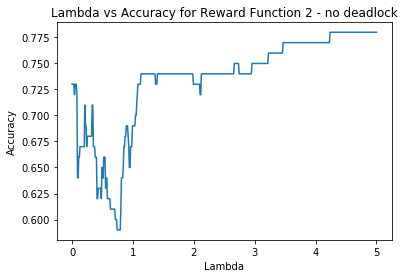

In [274]:
plt.plot(lambda_range, lam_vs_acc)
plt.title("Lambda vs Accuracy for Reward Function 2 - no deadlock")
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.show()

In [275]:
print("The highest accuracy is ", np.max(lam_vs_acc))
print("The lambda value with highest accuracy is ", lam_max_2)

The highest accuracy is  0.78
The lambda value with highest accuracy is  4.23847695391


In [276]:
extracted2_value2, extracted2_policy2 = value_iteration2(extracted2_reward2, state_space, actions, 0.1, discount=0.8, epsilon=0.01 )

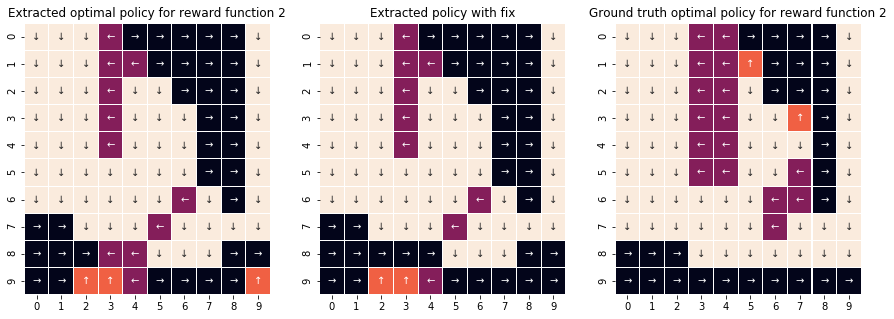

In [277]:
extracted2_policy2_arrows = arrow_conversion(extracted2_policy2)
fig, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].set_title("Extracted optimal policy for reward function 2")
sns.heatmap(extracted_policy2, annot=extracted_policy2_arrows, fmt='', linewidths=.1, cbar=False, ax=ax[0])
ax[1].set_title("Extracted policy with fix")
sns.heatmap(extracted2_policy2, annot=extracted2_policy2_arrows, fmt='', linewidths=.1, cbar=False, ax=ax[1])
plt.title("Ground truth optimal policy for reward function 2")
sns.heatmap(policy2, annot=policy2_arrows, fmt='', linewidths=.1, cbar=False, ax=ax[2])